# Imports

In [1]:
import numpy as np
import pandas as pd

import constants.constants as cst
import constants.paths as pth
from src.market_sim import compute_profit
from src.preprocessing import preprocess_data
from src.strategies import predict_rates
from src.utils.cumulative_probability import plot_cumulative_probability
from src.utils.load_data import load_data
from src.utils.model_utils import load_model


In [2]:
data_to_predict = load_data(pth.NEW_LOANS_PATH)

# Load preprocessor
preprocessor = load_model(
    model_name="XGBoost_Calibrated_Optimized_preprocessor", model_type="sklearn"
)

preprocessed_data_to_predict, _, _ = preprocess_data(
    data_to_predict, preprocessor=preprocessor, fit=False
)

2025-10-26 02:23:34.975 | INFO     | src.utils.model_utils:load_model:67 - Model loaded from: /home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/models/XGBoost_Calibrated_Optimized_preprocessor.pkl
2025-10-26 02:23:34.976 | INFO     | src.preprocessing:preprocess_data:67 - Applying log transformation to income
2025-10-26 02:23:34.978 | INFO     | src.preprocessing:preprocess_data:82 - Transforming data with existing preprocessor.
2025-10-26 02:23:34.976 | INFO     | src.preprocessing:preprocess_data:67 - Applying log transformation to income
2025-10-26 02:23:34.978 | INFO     | src.preprocessing:preprocess_data:82 - Transforming data with existing preprocessor.


In [3]:
# Make predictions
model = load_model(model_name="XGBoost_Calibrated_Optimized", model_type="sklearn")

proba_predictions = model.predict_proba(preprocessed_data_to_predict)[:, 1]

2025-10-26 02:23:35.083 | INFO     | src.utils.model_utils:load_model:67 - Model loaded from: /home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/models/XGBoost_Calibrated_Optimized.pkl


In [4]:
data_to_predict[cst.DEFAULT_PROBABILITY] = proba_predictions

The function
$$
f : x \mapsto \frac{x}{1-x}
$$
is strictly growing on $[0,1[$ and $f(\frac{1}{2})=1$.

Thus, any predicted default probability above $0.5$ gives a break even interest rate above $100\%$. We cannot fix interest rates above $100\%$.

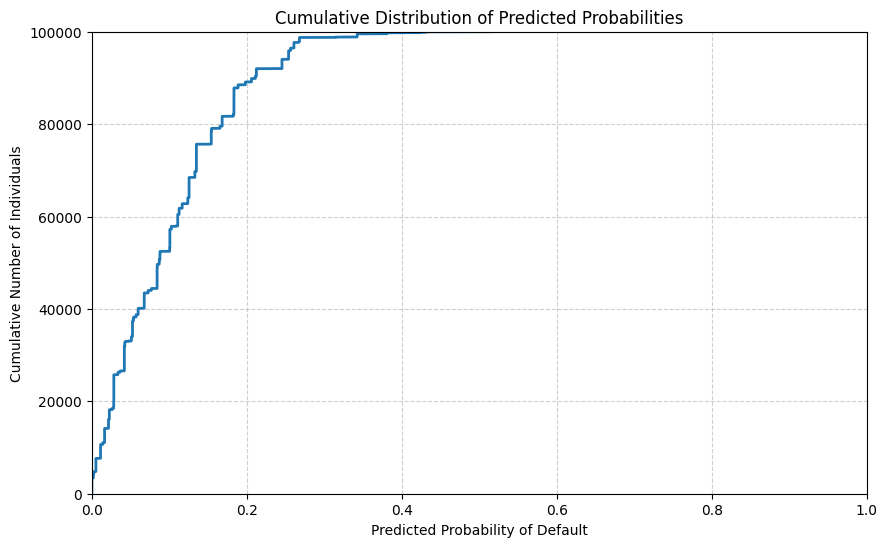

In [5]:
plot_cumulative_probability(data_to_predict[cst.DEFAULT_PROBABILITY])

In [6]:
data_to_predict_with_rates = predict_rates(
    data_to_predict,
    linear_params={"alpha_0": 0.2, "alpha_1": 0.1, "delta": 0.05},
    quadratic_params={"beta_0": 0.2, "beta_1": 0.1, "beta_2": 0.2, "gamma": 0.05},
)

In [7]:
data_to_predict_with_rates.describe()

,id,married,income,signal2,default_probability,break_even_rate,linear_rate,quadratic_rate
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,0.610960,7.850842,0.415483,0.099712,0.120011,0.329904,0.333043
std,28867.657797,0.487535,3.660144,0.324584,0.077865,0.108175,0.115328,0.119339
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000
25%,25000.750000,0.000000,8.587465,0.059857,0.028287,0.029111,0.231939,0.232099
50%,50000.500000,1.000000,9.143132,0.446035,0.086917,0.095190,0.303882,0.305393
75%,75000.250000,1.000000,9.766694,0.692073,0.134839,0.155855,0.369339,0.372975
max,100000.000000,1.000000,13.815512,0.999987,0.515152,1.062500,1.000000,1.000000


## Comparing new rates with round 1 rates

In [8]:
round_1_results = load_data(pth.RESULTS_PATH)

In [9]:
# Comparing linear rates
comparison_linear = round_1_results.copy()
comparison_linear = comparison_linear.drop(columns=[cst.PROFIT])

comparison_linear[cst.BANK_2_RATE] = data_to_predict_with_rates[cst.LINEAR_RATE]

comparison_linear = compute_profit(comparison_linear)

In [10]:
comparison_linear

,id,own,competing1,competing3,borrowertype,accepted,default,winner,profit_competing1,profit_own,profit_competing3
0,1,0.231693,0.054436,0.025796,3,0,0,competing3,<NA>,<NA>,257.95907
1,2,0.338035,0.186897,0.110289,1,0,1,competing3,<NA>,<NA>,-10000
2,3,0.247884,0.052648,0.100135,3,1,0,competing1,526.47717,<NA>,<NA>
3,4,0.300258,0.105168,0.090256,3,0,0,competing3,<NA>,<NA>,902.56438
4,5,0.488372,0.127306,0.194219,1,0,0,competing1,1273.0633,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,0.321891,0.160974,0.066152,3,0,0,competing3,<NA>,<NA>,661.5223
99996,99997,0.343505,0.200041,0.142413,3,0,0,competing3,<NA>,<NA>,1424.1314
99997,99998,0.355868,0.223306,NaN,3,1,0,competing1,2233.0594,<NA>,<NA>
99998,99999,0.212399,0.045920,0.010895,2,1,0,competing3,<NA>,<NA>,108.95047


In [11]:
comparison_linear["profit_own"].sum()

582354.598388281

In [12]:
# Comparing quadratic rates
comparison_quadratic = round_1_results.copy()
comparison_quadratic = comparison_quadratic.drop(columns=[cst.PROFIT])

comparison_quadratic[cst.BANK_2_RATE] = data_to_predict_with_rates[cst.QUADRATIC_RATE]

comparison_quadratic = compute_profit(comparison_quadratic)

In [13]:
comparison_quadratic

,id,own,competing1,competing3,borrowertype,accepted,default,winner,profit_competing1,profit_own,profit_competing3
0,1,0.231851,0.054436,0.025796,3,0,0,competing3,<NA>,<NA>,257.95907
1,2,0.340567,0.186897,0.110289,1,0,1,competing3,<NA>,<NA>,-10000
2,3,0.248234,0.052648,0.100135,3,1,0,competing1,526.47717,<NA>,<NA>
3,4,0.301674,0.105168,0.090256,3,0,0,competing3,<NA>,<NA>,902.56438
4,5,0.497269,0.127306,0.194219,1,0,0,competing1,1273.0633,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,0.323915,0.160974,0.066152,3,0,0,competing3,<NA>,<NA>,661.5223
99996,99997,0.346219,0.200041,0.142413,3,0,0,competing3,<NA>,<NA>,1424.1314
99997,99998,0.359011,0.223306,NaN,3,1,0,competing1,2233.0594,<NA>,<NA>
99998,99999,0.212424,0.045920,0.010895,2,1,0,competing3,<NA>,<NA>,108.95047


In [14]:
comparison_quadratic["profit_own"].sum()

532161.3483110297

## Optimize Parameters Using Market Simulation

Now let's use the optimization function to find the best parameters.

In [15]:
from src.market_sim import optimize_rate_params

# Define parameter grids to test
linear_param_grid = {
    "alpha_0": [0.05, 0.1, 0.15, 0.2, 0.25],
    "alpha_1": [0.0, 0.05, 0.1, 0.15, 0.2],
    "delta": [0.05, 0.1],
}

quadratic_param_grid = {
    "beta_0": [0.05, 0.1, 0.15, 0.2, 0.25],
    "beta_1": [0.0, 0.05, 0.1, 0.15],
    "beta_2": [0.0, 0.1, 0.2, 0.3],
    "gamma": [0.05, 0.1],
}

# Run optimization
best_linear, best_quadratic, optimization_results = optimize_rate_params(
    predictions_df=data_to_predict,
    market_results_df=round_1_results,
    linear_param_grid=linear_param_grid,
    quadratic_param_grid=quadratic_param_grid,
    strategy="both",
    verbose=True,
)

Optimizing linear strategy...
  Tested 5/50 linear combinations
  Tested 5/50 linear combinations
  Tested 10/50 linear combinations
  Tested 10/50 linear combinations
  Tested 15/50 linear combinations
  Tested 15/50 linear combinations
  Tested 20/50 linear combinations
  Tested 20/50 linear combinations
  Tested 25/50 linear combinations
  Tested 25/50 linear combinations
  Tested 30/50 linear combinations
  Tested 30/50 linear combinations
  Tested 35/50 linear combinations
  Tested 35/50 linear combinations
  Tested 40/50 linear combinations
  Tested 40/50 linear combinations
  Tested 45/50 linear combinations
  Tested 45/50 linear combinations
  Tested 50/50 linear combinations
Optimizing quadratic strategy...
  Tested 50/50 linear combinations
Optimizing quadratic strategy...
  Tested 16/160 quadratic combinations
  Tested 16/160 quadratic combinations
  Tested 32/160 quadratic combinations
  Tested 32/160 quadratic combinations
  Tested 48/160 quadratic combinations
  Tested 48

In [16]:
# View the optimization results sorted by profit
optimization_results.sort_values("total_profit", ascending=False).head(10)

,strategy,alpha_0,alpha_1,delta,total_profit,beta_0,beta_1,beta_2,gamma
80,quadratic,NaN,NaN,NaN,2.258005e+06,0.05,0.15,0.3,0.05
81,quadratic,NaN,NaN,NaN,2.258005e+06,0.05,0.15,0.3,0.10
9,linear,0.05,0.2,0.10,2.161449e+06,NaN,NaN,NaN,NaN
8,linear,0.05,0.2,0.05,2.161449e+06,NaN,NaN,NaN,NaN
78,quadratic,NaN,NaN,NaN,2.141374e+06,0.05,0.15,0.2,0.05
79,quadratic,NaN,NaN,NaN,2.141374e+06,0.05,0.15,0.2,0.10
76,quadratic,NaN,NaN,NaN,2.100485e+06,0.05,0.15,0.1,0.05
77,quadratic,NaN,NaN,NaN,2.100485e+06,0.05,0.15,0.1,0.10
73,quadratic,NaN,NaN,NaN,1.984150e+06,0.05,0.10,0.3,0.10
72,quadratic,NaN,NaN,NaN,1.984150e+06,0.05,0.10,0.3,0.05


In [17]:
# Test the best parameters found
data_optimized = predict_rates(
    data_to_predict,
    linear_params=best_linear,
    quadratic_params=best_quadratic,
)

# Compare with round 1 results
comparison_optimized_linear = round_1_results.copy()
comparison_optimized_linear[cst.BANK_2_RATE] = data_optimized[cst.LINEAR_RATE]
comparison_optimized_linear = compute_profit(comparison_optimized_linear)

comparison_optimized_quadratic = round_1_results.copy()
comparison_optimized_quadratic[cst.BANK_2_RATE] = data_optimized[cst.QUADRATIC_RATE]
comparison_optimized_quadratic = compute_profit(comparison_optimized_quadratic)

print(
    f"Optimized Linear Profit: ${comparison_optimized_linear['profit_own'].sum():,.2f}"
)
print(
    f"Optimized Quadratic Profit: ${comparison_optimized_quadratic['profit_own'].sum():,.2f}"
)

Optimized Linear Profit: $2,161,448.79
Optimized Quadratic Profit: $2,258,004.84


## Analyze Adverse Selection and Winner's Curse

Before finalizing our strategy, let's analyze if we're experiencing adverse selection in Round 1 results.

In [18]:
from src.market_sim import (
    analyze_adverse_selection,
    analyze_risk_segment_performance,
    suggest_risk_based_markup,
)

# Analyze adverse selection patterns
# Using the rates from earlier in the notebook
adverse_selection = analyze_adverse_selection(
    predictions_df=data_to_predict,
    market_results_df=round_1_results,
    our_rates=data_to_predict_with_rates[cst.LINEAR_RATE],
    bank_name=cst.BANK_2_RATE,
)

print("Adverse Selection Analysis (by how competitive our pricing was):")
print("=" * 70)
adverse_selection

Adverse Selection Analysis (by how competitive our pricing was):


/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/src/market_sim.py:47: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df[cst.WINNER] = rates_df.idxmin(axis=1)


,win_rate,loan_count,actual_default_rate_when_won,predicted_default_rate_when_won
rate_gap_quintile,,,,
Much Cheaper,0.7701,20001,0.0980,0.0730
Cheaper,0.5954,19998,0.0491,0.0455
Similar,0.3366,20002,0.0469,0.0434
More Exp,0.1492,19997,0.0784,0.0782
Much More Exp,0.0231,20000,0.2316,0.1674


In [19]:
# Analyze performance by risk segment
risk_segment_analysis = analyze_risk_segment_performance(
    predictions_df=data_to_predict,
    market_results_df=round_1_results,
    our_rates=data_to_predict_with_rates[cst.LINEAR_RATE],
    bank_name=cst.BANK_2_RATE,
    n_segments=5,
)

print("\nRisk Segment Performance Analysis:")
print("=" * 70)
risk_segment_analysis


Risk Segment Performance Analysis:


/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/src/market_sim.py:47: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df[cst.WINNER] = rates_df.idxmin(axis=1)


,avg_pred_default,min_pred_default,max_pred_default,loans_won,win_rate,actual_default_rate,total_profit,avg_profit_per_loan,avg_rate_charged,expected_default_rate,prediction_error
risk_segment,,,,,,,,,,,
Q1,0.0124,0.0000,0.0281,11807,0.5881,0.0162,2.304923e+07,1148.0986,0.2150,0.0124,0.0038
Q2,0.0421,0.0282,0.0597,10780,0.5379,0.0475,2.012238e+07,1004.1109,0.2460,0.0421,0.0054
Q3,0.0892,0.0603,0.1107,7823,0.3850,0.1071,1.304096e+07,641.8744,0.3069,0.0892,0.0179
Q4,0.1369,0.1125,0.1681,6423,0.3023,0.1607,9.450682e+06,444.7798,0.3672,0.1369,0.0238
Q5,0.2269,0.1824,0.5152,653,0.0356,0.2741,3.757681e+05,20.5125,0.4592,0.2269,0.0472


In [20]:
# Get suggestions for markup adjustments
suggestions = suggest_risk_based_markup(
    adverse_selection_analysis=adverse_selection,
    risk_segment_analysis=risk_segment_analysis,
    base_markup=0.05,
)

print("\nSuggested Adjustments:")
print("=" * 70)
for reason in suggestions["reasoning"]:
    print(reason)
print(f"\nSuggested adjustments: {suggestions['adjustments']}")


Suggested Adjustments:
⚠️  Adverse selection detected: When pricing much cheaper, actual defaults exceed predictions by >10%. Consider adding 2% markup.

Suggested adjustments: {'adverse_selection_penalty': 0.02}


### Key Insights for Winner's Curse Mitigation

**What to look for in the analysis above:**

1. **Adverse Selection Analysis**: 
   - If "actual_default_rate_when_won" > "predicted_default_rate_when_won" when you're "Much Cheaper", you're experiencing adverse selection
   - This means competitors see risk you're missing → increase your markup

2. **Risk Segment Analysis**:
   - Look at "prediction_error" (actual - predicted default rate)
   - Positive errors = you're underestimating risk in that segment
   - Negative "avg_profit_per_loan" = avoid that segment or charge much more

3. **Strategy Adjustment**:
   - If adverse selection is detected, add the suggested penalty to your base markup
   - Consider risk-dependent markups: higher for uncertain/high-risk segments

## Risk-Tiered Strategy (Winner's Curse Mitigation)

Based on the analysis above, we can use a risk-tiered approach that charges different markups for different risk levels.

In [21]:
from src.strategies import risk_tiered_strategy

# Apply risk-tiered strategy
# More conservative (higher markup) for high-risk loans where adverse selection is likely
data_risk_tiered = risk_tiered_strategy(
    predictions=data_to_predict,
    low_risk_markup=0.05,  # Aggressive on low risk (we're confident)
    medium_risk_markup=0.10,  # Moderate on medium risk
    high_risk_markup=0.20,  # Conservative on high risk (more uncertainty)
    low_threshold=0.15,  # Below 15% default probability = low risk
    high_threshold=0.35,  # Above 35% default probability = high risk
    min_delta=0.05,
)

# Test on Round 1 results
comparison_tiered = round_1_results.copy()
comparison_tiered[cst.BANK_2_RATE] = data_risk_tiered["risk_tiered_rate"]
comparison_tiered = compute_profit(comparison_tiered)

print(f"Risk-Tiered Strategy Profit: ${comparison_tiered['profit_own'].sum():,.2f}")
print(f"\nFor comparison:")
print(f"Linear Strategy Profit: ${comparison_linear['profit_own'].sum():,.2f}")
print(f"Quadratic Strategy Profit: ${comparison_quadratic['profit_own'].sum():,.2f}")

Risk-Tiered Strategy Profit: $2,269,803.51

For comparison:
Linear Strategy Profit: $582,354.60
Quadratic Strategy Profit: $532,161.35


## Recommended Workflow for Round 2 Strategy Selection

### Step-by-Step Process:

**STEP 1: Analyze Historical Performance (Diagnostic)**
- Run `analyze_adverse_selection()` and `analyze_risk_segment_performance()` 
- Use your **Round 1 actual rates** to understand what went wrong/right
- Identifies if you experienced winner's curse in Round 1

**STEP 2: Get Markup Recommendations (Guidance)**
- Run `suggest_risk_based_markup()` based on Step 1 analysis
- This tells you how to adjust your strategy parameters

**STEP 3: Optimize Strategy Parameters (Search)**
- Run `optimize_rate_params()` with appropriate parameter grids
- Test linear, quadratic, AND risk-tiered strategies
- Grid should reflect insights from Step 2 (e.g., higher markups if adverse selection detected)

**STEP 4: Compare All Strategies (Selection)**
- Compare optimized linear, optimized quadratic, and risk-tiered on Round 1 data
- Choose the strategy that:
  - Maximizes profit on Round 1
  - Shows NO adverse selection patterns
  - Performs well across all risk segments

**STEP 5: Apply to Round 2 (Deployment)**
- Use winning strategy with optimal parameters on NEW Round 2 applicants

### STEP 1: Analyze Your Round 1 Performance (What Actually Happened)

In [ ]:
# Extract YOUR actual Round 1 rates (what you actually used in competition)
round_1_our_rates = round_1_results[cst.BANK_2_RATE]

# Analyze if you experienced adverse selection with your Round 1 strategy
adverse_selection_round1 = analyze_adverse_selection(
    predictions_df=data_to_predict,
    market_results_df=round_1_results,
    our_rates=round_1_our_rates,  # Your actual Round 1 rates
    bank_name=cst.BANK_2_RATE,
)

print("STEP 1: Your Round 1 Adverse Selection Analysis")
print("=" * 80)
print("\nDid you win worse loans when pricing aggressively?")
display(adverse_selection_round1)

STEP 1: Your Round 1 Adverse Selection Analysis

Did you win worse loans when pricing aggressively?


/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/src/market_sim.py:47: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df[cst.WINNER] = rates_df.idxmin(axis=1)


,win_rate,loan_count,actual_default_rate_when_won,predicted_default_rate_when_won
rate_gap_quintile,,,,
Much Cheaper,1.0000,16500,0.0991,0.0743
Cheaper,0.7182,16500,0.0541,0.0483
Similar,0.3982,16500,0.0528,0.0527
More Exp,0.1555,16500,0.0503,0.0480
Much More Exp,0.0000,16500,NaN,NaN


In [23]:
# Analyze which risk segments performed well/poorly in Round 1
risk_segment_round1 = analyze_risk_segment_performance(
    predictions_df=data_to_predict,
    market_results_df=round_1_results,
    our_rates=round_1_our_rates,  # Your actual Round 1 rates
    bank_name=cst.BANK_2_RATE,
    n_segments=5,
)

print("\nRisk Segment Performance (Round 1 Actual):")
print("=" * 80)
print("Which risk levels were profitable? Where did you underestimate defaults?")
display(risk_segment_round1)


Risk Segment Performance (Round 1 Actual):
Which risk levels were profitable? Where did you underestimate defaults?


/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/src/market_sim.py:47: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df[cst.WINNER] = rates_df.idxmin(axis=1)


,avg_pred_default,min_pred_default,max_pred_default,loans_won,win_rate,actual_default_rate,total_profit,avg_profit_per_loan,avg_rate_charged,expected_default_rate,prediction_error
risk_segment,,,,,,,,,,,
Q1,0.0124,0.0000,0.0281,11807,0.5881,0.0162,694458.3675,34.5915,0.0224,0.0124,0.0038
Q2,0.0421,0.0282,0.0597,10780,0.5379,0.0475,-89845.1844,-4.4833,0.0492,0.0421,0.0054
Q3,0.0892,0.0603,0.1107,7823,0.3850,0.1071,-415493.2702,-20.4505,0.1144,0.0892,0.0179
Q4,0.1369,0.1125,0.1681,6423,0.3023,0.1607,-857741.4206,-40.3681,0.1760,0.1369,0.0238
Q5,0.2269,0.1824,0.5152,653,0.0356,0.2741,-868430.8526,-47.4060,0.1941,0.2269,0.0472


### STEP 2: Get Recommendations Based on Round 1 Results

In [ ]:
# Get automated suggestions for how to adjust your strategy
suggestions_round1 = suggest_risk_based_markup(
    adverse_selection_analysis=adverse_selection_round1,
    risk_segment_analysis=risk_segment_round1,
    base_markup=0.05,
)

print("\nSTEP 2: Recommended Adjustments for Round 2")
print("=" * 80)
if suggestions_round1["reasoning"]:
    for reason in suggestions_round1["reasoning"]:
        print(f"  {reason}")
    print(f"\n  Suggested parameter adjustments: {suggestions_round1['adjustments']}")
else:
    print("   No major issues detected in Round 1 strategy!")
    print("   Consider slight optimization but your approach is sound.")


STEP 2: Recommended Adjustments for Round 2
  ⚠️  Adverse selection detected: When pricing much cheaper, actual defaults exceed predictions by >10%. Consider adding 2% markup.
  ❌ Risk segment Q2: Negative profit. Consider avoiding or increasing markup significantly.
  ❌ Risk segment Q3: Negative profit. Consider avoiding or increasing markup significantly.
  ❌ Risk segment Q4: Negative profit. Consider avoiding or increasing markup significantly.
  ❌ Risk segment Q5: Negative profit. Consider avoiding or increasing markup significantly.

  Suggested parameter adjustments: {'adverse_selection_penalty': 0.02}


### STEP 3: Optimize Strategy Parameters (Grid Search)

Now use the insights from Steps 1-2 to define your parameter grids and optimize.

In [25]:
# Define parameter grids based on Step 2 recommendations
# If adverse selection detected, test HIGHER markups
# If no issues, can test a wider range including lower markups

print("STEP 3: Optimizing Strategy Parameters")
print("=" * 80)

# PHASE 1: COARSE GRID - Quick exploration (reasonable number of tests)
# Start with ~10-15 values per parameter = manageable number of combinations
# Linear: 10 × 10 × 3 = 300 combinations
# Quadratic: 10 × 8 × 8 × 3 = 1,920 combinations
# Total: ~2,220 simulations (very reasonable!)

linear_param_grid_optimized = {
    "alpha_0": [
        0.00,
        0.05,
        0.10,
        0.15,
        0.20,
        0.25,
        0.30,
        0.35,
        0.40,
        0.50,
    ],  # Base markup
    "alpha_1": [
        0.00,
        0.05,
        0.10,
        0.15,
        0.20,
        0.25,
        0.30,
        0.40,
        0.50,
        0.60,
    ],  # Risk component
    "delta": [0.03, 0.05, 0.10],  # Minimum markup (fewer values needed)
}

quadratic_param_grid_optimized = {
    "beta_0": [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.50],
    "beta_1": [0.00, 0.05, 0.10, 0.15, 0.20, 0.30, 0.40, 0.50],
    "beta_2": [0.00, 0.05, 0.10, 0.15, 0.20, 0.30, 0.40, 0.50],
    "gamma": [0.03, 0.05, 0.10],
}

print(
    f"Linear combinations: {len(linear_param_grid_optimized['alpha_0']) * len(linear_param_grid_optimized['alpha_1']) * len(linear_param_grid_optimized['delta'])}"
)
print(
    f"Quadratic combinations: {len(quadratic_param_grid_optimized['beta_0']) * len(quadratic_param_grid_optimized['beta_1']) * len(quadratic_param_grid_optimized['beta_2']) * len(quadratic_param_grid_optimized['gamma'])}"
)

# Run optimization
best_linear_opt, best_quadratic_opt, optimization_results_v2 = optimize_rate_params(
    predictions_df=data_to_predict,
    market_results_df=round_1_results,
    linear_param_grid=linear_param_grid_optimized,
    quadratic_param_grid=quadratic_param_grid_optimized,
    strategy="both",
    verbose=True,
)

STEP 3: Optimizing Strategy Parameters
Linear combinations: 300
Quadratic combinations: 1920
Optimizing linear strategy...


  Tested 30/300 linear combinations
  Tested 60/300 linear combinations
  Tested 60/300 linear combinations
  Tested 90/300 linear combinations
  Tested 90/300 linear combinations
  Tested 120/300 linear combinations
  Tested 120/300 linear combinations
  Tested 150/300 linear combinations
  Tested 150/300 linear combinations
  Tested 180/300 linear combinations
  Tested 180/300 linear combinations
  Tested 210/300 linear combinations
  Tested 210/300 linear combinations
  Tested 240/300 linear combinations
  Tested 240/300 linear combinations
  Tested 270/300 linear combinations
  Tested 270/300 linear combinations
  Tested 300/300 linear combinations
Optimizing quadratic strategy...
  Tested 300/300 linear combinations
Optimizing quadratic strategy...
  Tested 192/1920 quadratic combinations
  Tested 192/1920 quadratic combinations
  Tested 384/1920 quadratic combinations
  Tested 384/1920 quadratic combinations
  Tested 576/1920 quadratic combinations
  Tested 576/1920 quadratic com

#### Optional: Phase 2 - Fine-Tuning (Run only if you want to refine further)

If Phase 1 found promising parameters, you can create a narrower grid around those values.
For example, if best alpha_0 was 0.15, test [0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18] in that region.

In [27]:
# PHASE 2: FINE GRID (Optional - only if you want to refine)
# Uncomment and adjust based on Phase 1 results

# Example: If Phase 1 found alpha_0=0.15 was best, zoom in around that
linear_param_grid_fine = {
    "alpha_0": np.linspace(0.02, 0.15, 20),  # Around best value
    "alpha_1": np.linspace(0.18, 0.32, 30),  # Around best value
    "delta": np.linspace(0.01, 0.07, 10),
}

quadratic_param_grid_fine = {
    "beta_0": np.linspace(0.02, 0.15, 20),
    "beta_1": np.linspace(0.15, 0.30, 30),
    "beta_2": np.linspace(0.2, 0.4, 20),
    "gamma": np.linspace(0.01, 0.07, 10),
}

best_linear_fine, _, _ = optimize_rate_params(
    predictions_df=data_to_predict,
    market_results_df=round_1_results,
    linear_param_grid=linear_param_grid_fine,
    quadratic_param_grid=quadratic_param_grid_fine,
    strategy="both",
    verbose=True,
)

Optimizing linear strategy...
  Tested 600/6000 linear combinations
  Tested 600/6000 linear combinations
  Tested 1200/6000 linear combinations
  Tested 1200/6000 linear combinations
  Tested 1800/6000 linear combinations
  Tested 1800/6000 linear combinations
  Tested 2400/6000 linear combinations
  Tested 2400/6000 linear combinations
  Tested 3000/6000 linear combinations
  Tested 3000/6000 linear combinations
  Tested 3600/6000 linear combinations
  Tested 3600/6000 linear combinations
  Tested 4200/6000 linear combinations
  Tested 4200/6000 linear combinations
  Tested 4800/6000 linear combinations
  Tested 4800/6000 linear combinations
  Tested 5400/6000 linear combinations
  Tested 5400/6000 linear combinations
  Tested 6000/6000 linear combinations
Optimizing quadratic strategy...
  Tested 6000/6000 linear combinations
Optimizing quadratic strategy...
  Tested 12000/120000 quadratic combinations
  Tested 12000/120000 quadratic combinations
  Tested 24000/120000 quadratic comb

In [31]:
best_quadratic_fine = {
    "beta_0": np.float64(0.03368421052631579),
    "beta_1": np.float64(0.2844827586206896),
    "beta_2": np.float64(0.368421052631579),
    "gamma": np.float64(0.01),
}

### STEP 4: Test Risk-Tiered Strategy as Alternative

In [28]:
# Test risk-tiered strategy with parameters informed by risk segment analysis
# Adjust thresholds based on where segments became unprofitable in Step 1

data_tiered_opt = risk_tiered_strategy(
    predictions=data_to_predict,
    low_risk_markup=0.05,  # Competitive on low risk
    medium_risk_markup=0.12,  # More conservative on medium
    high_risk_markup=0.25,  # Very conservative on high risk
    low_threshold=0.15,
    high_threshold=0.35,
    min_delta=0.05,
)

comparison_tiered_opt = round_1_results.copy()
comparison_tiered_opt[cst.BANK_2_RATE] = data_tiered_opt["risk_tiered_rate"]
comparison_tiered_opt = compute_profit(comparison_tiered_opt)

print(f"\nRisk-Tiered Profit: ${comparison_tiered_opt['profit_own'].sum():,.2f}")


Risk-Tiered Profit: $2,335,811.79


### STEP 5: Compare ALL Strategies and Check for Adverse Selection

In [39]:
# Generate rates for all strategies
data_all_strategies = predict_rates(
    data_to_predict,
    linear_params=best_linear_fine,
    quadratic_params=best_quadratic_fine,
)

# Calculate profits for each strategy
strategies_comparison = pd.DataFrame(
    {
        "Strategy": [
            "Round 1 Actual",
            "Optimized Linear",
            "Optimized Quadratic",
            "Risk-Tiered",
        ],
        "Total_Profit": [
            round_1_results["profit"].sum(),
            0,
            0,
            0,
        ],
    }
)

# Optimized Linear
comp_lin = round_1_results.copy()
comp_lin[cst.BANK_2_RATE] = data_all_strategies[cst.LINEAR_RATE]
comp_lin = compute_profit(comp_lin)
strategies_comparison.loc[1, "Total_Profit"] = comp_lin[
    f"profit_{cst.BANK_2_RATE}"
].sum()

# Optimized Quadratic
comp_quad = round_1_results.copy()
comp_quad[cst.BANK_2_RATE] = data_all_strategies[cst.QUADRATIC_RATE]
comp_quad = compute_profit(comp_quad)
strategies_comparison.loc[2, "Total_Profit"] = comp_quad[
    f"profit_{cst.BANK_2_RATE}"
].sum()

# Risk-Tiered
strategies_comparison.loc[3, "Total_Profit"] = comparison_tiered_opt[
    f"profit_{cst.BANK_2_RATE}"
].sum()

print("\nSTEP 5: Strategy Performance Comparison on Round 1 Data")
print("=" * 80)
strategies_comparison = strategies_comparison.sort_values(
    "Total_Profit", ascending=False
)
display(strategies_comparison)


STEP 5: Strategy Performance Comparison on Round 1 Data


,Strategy,Total_Profit
2,Optimized Quadratic,3.391523e+06
1,Optimized Linear,3.180734e+06
3,Risk-Tiered,2.335812e+06
0,Round 1 Actual,-1.537052e+06


In [ ]:
# CRITICAL: Check if top strategies still show adverse selection
print("\nAdverse Selection Check for Top Strategies:")
print("=" * 80)

# Check round 1 rates
adverse_selection_round_1 = analyze_adverse_selection(
    predictions_df=data_to_predict,
    market_results_df=round_1_results,
    our_rates=round_1_our_rates,
    bank_name=cst.BANK_2_RATE,
)

# Check optimized linear
adverse_linear_opt = analyze_adverse_selection(
    predictions_df=data_to_predict,
    market_results_df=round_1_results,
    our_rates=data_all_strategies[cst.LINEAR_RATE],
    bank_name=cst.BANK_2_RATE,
)

# Check optimized quadratic
adverse_quadratic_opt = analyze_adverse_selection(
    predictions_df=data_to_predict,
    market_results_df=round_1_results,
    our_rates=data_all_strategies[cst.QUADRATIC_RATE],
    bank_name=cst.BANK_2_RATE,
)

# Check risk-tiered
adverse_tiered_opt = analyze_adverse_selection(
    predictions_df=data_to_predict,
    market_results_df=round_1_results,
    our_rates=data_tiered_opt["risk_tiered_rate"],
    bank_name=cst.BANK_2_RATE,
)

print("\nRound 1 - Adverse Selection:")
display(adverse_selection_round_1)

print("\nOptimized Linear - Adverse Selection:")
display(adverse_linear_opt)

print("\nOptimized Quadratic - Adverse Selection:")
display(adverse_quadratic_opt)

print("\nRisk-Tiered - Adverse Selection:")
display(adverse_tiered_opt)


Adverse Selection Check for Top Strategies:

Round 1 - Adverse Selection:


/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/src/market_sim.py:47: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df[cst.WINNER] = rates_df.idxmin(axis=1)
/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/src/market_sim.py:47: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df[cst.WINNER] = rates_df.idxmin(axis=1)
/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/src/market_sim.py:47: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df[cst.WINNER] = rates_df.idxmin(axis=1)
/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/src/market_sim.py:47: FutureWarning: Th

,win_rate,loan_count,actual_default_rate_when_won,predicted_default_rate_when_won
rate_gap_quintile,,,,
Much Cheaper,1.0000,16500,0.0991,0.0743
Cheaper,0.7182,16500,0.0541,0.0483
Similar,0.3982,16500,0.0528,0.0527
More Exp,0.1555,16500,0.0503,0.0480
Much More Exp,0.0000,16500,NaN,NaN



Optimized Linear - Adverse Selection:


,win_rate,loan_count,actual_default_rate_when_won,predicted_default_rate_when_won
rate_gap_quintile,,,,
Much Cheaper,0.8174,20000,0.0812,0.0605
Cheaper,0.5632,20000,0.0543,0.0447
Similar,0.3458,19999,0.0593,0.0602
More Exp,0.1244,19999,0.1141,0.1105
Much More Exp,0.0234,20000,0.2516,0.1792



Optimized Quadratic - Adverse Selection:


,win_rate,loan_count,actual_default_rate_when_won,predicted_default_rate_when_won
rate_gap_quintile,,,,
Much Cheaper,0.8270,20000,0.0800,0.0597
Cheaper,0.5567,19999,0.0539,0.0442
Similar,0.3434,20000,0.0604,0.0616
More Exp,0.1240,19999,0.1185,0.1132
Much More Exp,0.0232,20000,0.2565,0.1828



Risk-Tiered - Adverse Selection:


,win_rate,loan_count,actual_default_rate_when_won,predicted_default_rate_when_won
rate_gap_quintile,,,,
Much Cheaper,0.8023,20000,0.0952,0.0724
Cheaper,0.5704,19999,0.0468,0.0427
Similar,0.3201,20000,0.0409,0.0392
More Exp,0.1448,19999,0.0915,0.0817
Much More Exp,0.0368,20000,0.2228,0.1799



⚠️  KEY DECISION CRITERIA:
Choose strategy that:
  1. Has highest profit
  2. Shows NO adverse selection (actual defaults ≈ predicted when 'Much Cheaper')
  3. Has consistent performance across risk segments


### STEP 6: Final Decision and Export for Round 2

Based on the analysis above, select your winning strategy and prepare for Round 2.

In [ ]:
CHOSEN_STRATEGY = "optimized_quadratic"
# Options: "optimized_linear", "optimized_quadratic", "risk_tiered"

print(f"✓ Selected Strategy: {CHOSEN_STRATEGY}")
print("=" * 80)


if CHOSEN_STRATEGY == "optimized_linear":
    final_params = {"strategy_type": "linear", "parameters": best_linear_opt}
    print(f"\nFinal Linear Parameters: {best_linear_opt}")

elif CHOSEN_STRATEGY == "optimized_quadratic":
    final_params = {"strategy_type": "quadratic", "parameters": best_quadratic_fine}
    print(f"\nFinal Quadratic Parameters: {best_quadratic_fine}")

elif CHOSEN_STRATEGY == "risk_tiered":
    final_params = {
        "strategy_type": "risk_tiered",
        "parameters": {
            "low_risk_markup": 0.05,
            "medium_risk_markup": 0.12,
            "high_risk_markup": 0.25,
            "low_threshold": 0.15,
            "high_threshold": 0.35,
            "min_delta": 0.05,
        },
    }
    print(f"\nFinal Risk-Tiered Parameters: {final_params['parameters']}")

✓ Selected Strategy: optimized_quadratic

Final Quadratic Parameters: {'beta_0': np.float64(0.03368421052631579), 'beta_1': np.float64(0.2844827586206896), 'beta_2': np.float64(0.368421052631579), 'gamma': np.float64(0.01)}

✓ These parameters are now ready to use on Round 2 applicants!
